<a href="https://colab.research.google.com/github/kesaroid/EIP-3.0-Phase-2/blob/master/Residual_Heatmaps_A5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Resnet Architecture for Tiny Imagenet

### Import Libraries and define global variables

In [0]:
import os
import numpy as np
import tensorflow as tf
import scipy.misc
import keras
import six
import pandas as pd
from imgaug import augmenters as iaa
from keras.utils.vis_utils import plot_model
from keras.models import Model, load_model
from keras.layers import Input, Activation, Flatten, Dropout, GlobalAveragePooling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D, SeparableConv2D
from keras.layers.merge import add
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras import backend as K
from keras.callbacks import *
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping, ModelCheckpoint

batch_size = 512           # For 64x64 = 128
nb_class = 200
nb_epoch = 50
img_per_class = 500
data_augmentation = True

# input image dimensions
img_height, img_width = 64, 64
channels = 3

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!wget 'http://cs231n.stanford.edu/tiny-imagenet-200.zip'
!unzip -qq 'tiny-imagenet-200.zip'

In [0]:
!ls

gdrive	sample_data  tiny-imagenet-200	tiny-imagenet-200.zip


### Load Data and Data augmentation techniques


In [0]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug)
seq = iaa.Sequential([
                      iaa.GaussianBlur(sigma=(0, 2.0)),
                      iaa.Fliplr(0.5),
                      iaa.CoarseDropout(p=0.1, size_percent=0.15),
                      iaa.ContrastNormalization((0.75, 1.5)),
                              sometimes(iaa.Affine(
                                                    scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                                                    translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                                                    rotate=(-30, 30),
                                                    shear=(-16, 16)))
      ])

if data_augmentation==True:
  train_datagen = ImageDataGenerator(
      rescale= 1./255,
      preprocessing_function=seq.augment_image
      )
else:
  train_datagen = ImageDataGenerator(
      rescale= 1./255
      )

valid_datagen = ImageDataGenerator(rescale=1./255)

In [0]:
train_generator = train_datagen.flow_from_directory( r'./tiny-imagenet-200/train/', 
                                                    target_size=(img_height, img_width),
                                                    color_mode='rgb',
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True, seed=None)

Found 100000 images belonging to 200 classes.


In [0]:
val_data = pd.read_csv('./tiny-imagenet-200/val/val_annotations.txt', sep='\t', header=None, names=['File', 'Class', 'X', 'Y', 'H', 'W'])
val_data.drop(['X', 'Y', 'H', 'W'], axis=1, inplace=True)

validation_generator = valid_datagen.flow_from_dataframe(val_data, directory='./tiny-imagenet-200/val/images/', 
                                                         x_col='File', y_col='Class',
                                                         target_size=(img_height, img_width),
                                                         color_mode='rgb', class_mode='categorical', 
                                                         batch_size=batch_size, shuffle=False, seed=None)

# Get all data from dataset

def load_tiny_data(path, dtype=np.float32):
  
  # First load wnids
  wnids_file = os.path.join(path, 'wnids.txt')
  with open(os.path.join(wnids_file), 'r') as f:
    wnids = [x.strip() for x in f]
  wnids.sort()
  
  # Map wnids to integer labels
  wnid_to_label = {wnid: i for i, wnid in enumerate(wnids)}

  # Use words.txt to get names for each class
  words_file = os.path.join(path, 'words.txt')
  with open(os.path.join(words_file), 'r') as f:
    wnid_to_words = dict(line.split('\t') for line in f)
  
  return wnids, wnid_to_label, wnid_to_words

wnids, wnid_to_label, wnid_to_words = load_tiny_data(path='tiny-imagenet-200/')
print('Training/Validation Data is created')

Found 10000 validated image filenames belonging to 200 classes.
Training/Validation Data is created


In [0]:
X_train, y_train = next(train_generator)
X_test, y_test = next(validation_generator)

print("X_train Shape: ",X_train.shape)
print("y_train Shape: ",y_train.shape)
print("X_test Shape: ",X_test.shape)
print("y_test Shape: ",y_test.shape)

X_train Shape:  (128, 64, 64, 3)
y_train Shape:  (128, 200)
X_test Shape:  (128, 64, 64, 3)
y_test Shape:  (128, 200)


### Define model architecture

In [0]:
def bn_relu(conv):
    normalize = BatchNormalization()(conv)
    return Activation("relu")(normalize)
  
def conv_block(input_shape, filters, bottleneck, repetition=2, padding='same'):
  for i in range(repetition):
    if i == 0:
      convolution = Conv2D(filters=filters, kernel_size=(3,3), padding=padding)(input_shape)
    else:
      convolution = Conv2D(filters=filters, kernel_size=(3,3), padding=padding)(activation)
    
    activation = bn_relu(convolution)
    filters *= 2

  if input_shape.shape[3] != activation.shape[3]:
    input_shape = Conv2D(filters=int(activation.shape[3]), kernel_size=(1,1))(input_shape)
  
  concatenate = add([activation, input_shape])
  
  if bottleneck==0:
    return concatenate
  else:
    output_shape = Conv2D(filters=bottleneck, kernel_size=(1,1), activation='relu')(concatenate)
    return output_shape

In [0]:
input = Input(shape=(None, None, channels))               # img_height, img_width


block1 = conv_block(input_shape=input, filters=32, bottleneck=0)
block2 = conv_block(input_shape=block1, filters=64, bottleneck=64)
block3 = MaxPooling2D(pool_size=(2,2))(block2)
block4 = conv_block(input_shape=block3, filters=64, bottleneck=0)
block5 = conv_block(input_shape=block4, filters=128, bottleneck=128)
block6 = conv_block(input_shape=block5, filters=128, bottleneck=0)
block7 = conv_block(input_shape=block6, filters=256, bottleneck=0)
block8 = MaxPooling2D(pool_size=(2,2))(block7)
block9 = conv_block(input_shape=block8, filters=512, bottleneck=200)


output = GlobalAveragePooling2D()(block9)
output = Activation('softmax')(output)

model = Model(inputs=input, outputs=output)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [0]:
model= load_model('gdrive/My Drive/EIP/A4/original_residual_extra.h5')           #  = load_model    .load_weights
print('Model/Weights from previous session loaded')

W0625 06:33:24.375777 140672737597312 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0625 06:33:24.438908 140672737597312 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0625 06:33:24.479589 140672737597312 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0625 06:33:24.480849 140672737597312 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0625 06:33:24.484395 140672737

Model/Weights from previous session loaded


In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])

checkpoint = ModelCheckpoint('gdrive/My Drive/EIP/original_residual_extra.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
lr_reducer = ReduceLROnPlateau(monitor='val_acc', mode='auto', factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
csv_logger = CSVLogger('gdrive/My Drive/EIP/resnet_tiny1.csv')

### Train

In [0]:
model.fit_generator(train_generator, 
                    epochs=2,               #nb_epoch, 
                    steps_per_epoch=(img_per_class * nb_class) // batch_size,
                    class_weight=class_weights,
                    validation_steps=200, 
                    validation_data=validation_generator, 
                    callbacks=[checkpoint, csv_logger, lr_reducer])

Epoch 1/2
781/781 [==============================] - 1266s 2s/step - loss: 0.2476 - acc: 0.9298 - val_loss: 2.6843 - val_acc: 0.5674

Epoch 00001: val_acc improved from -inf to 0.56739, saving model to gdrive/My Drive/EIP/original_residual_extra.h5
Epoch 2/2
781/781 [==============================] - 1265s 2s/step - loss: 0.2399 - acc: 0.9328 - val_loss: 2.6768 - val_acc: 0.5637

Epoch 00002: val_acc did not improve from 0.56739


### Predict and Retrieve missclassified images

In [0]:
# [Classwise]

y_pred = model.predict_generator(validation_generator, steps=20) # Steps 20 only if batch_size = 512
y_pred = np.argmax(y_pred, axis=1)
y_true = validation_generator.classes

In [0]:
actual_words = []
for i in val_data.Class:
  actual_words.append(wnid_to_words[i])
  
df = pd.DataFrame({'File Name': val_data.File, 'actual label': val_data.Class, 'actual words': actual_words, 'actual pred': y_true, 'predictions': y_pred}, 
                  columns=['File Name', 'actual label', 'actual words', 'actual pred', 'predictions'])
df.to_csv('gdrive/My Drive/EIP/A4/prediction_classwise.csv')

df['correct'] = np.where(df['actual pred'] == df['predictions'], df['actual label'], 'Nan')
hard_df = df.loc[df['correct'] != 'Nan']

hard_df_count = hard_df.groupby(['actual pred']).size().reset_index(name='count')
dict_labels_vs_samples = hard_df_count.set_index('actual pred').T.to_dict('index').pop('count')

In [0]:
hard_df

File Name actual label  ... predictions    correct
0        val_0.JPEG    n03444034  ...         107  n03444034
4        val_4.JPEG    n02808440  ...          69  n02808440
5        val_5.JPEG    n04399382  ...         161  n04399382
6        val_6.JPEG    n04179913  ...         147  n04179913
7        val_7.JPEG    n02823428  ...          73  n02823428
8        val_8.JPEG    n04146614  ...         145  n04146614
10      val_10.JPEG    n04371430  ...         158  n04371430
17      val_17.JPEG    n04486054  ...         165  n04486054
19      val_19.JPEG    n03763968  ...         119  n03763968
21      val_21.JPEG    n03837869  ...         124  n03837869
24      val_24.JPEG    n04532670  ...         170  n04532670
25      val_25.JPEG    n04074963  ...         141  n04074963
26      val_26.JPEG    n04540053  ...         171  n04540053
28      val_28.JPEG    n02906734  ...          79  n02906734
29      val_29.JPEG    n02094433  ...          25  n02094433
31      val_31.JPEG    n07614500  ...         179  n07614500
33      val_33.JPEG    n03937543  ...         130  n03937543
35      val_35.JPEG    n02977058  ...          86  n02977058
36      val_36.JPEG    n01768244  ...           6  n01768244
39      val_39.JPEG    n03891332  ...         127  n03891332
41      val_41.JPEG    n02125311  ...          33  n02125311
42      val_42.JPEG    n02279972  ...          44  n02279972
47      val_47.JPEG    n07720875  ...         184  n07720875
51      val_51.JPEG    n02129165  ...          34  n02129165
52      val_52.JPEG    n02226429  ...          39  n02226429
53      val_53.JPEG    n01917289  ...          14  n01917289
54      val_54.JPEG    n02841315  ...          75  n02841315
55      val_55.JPEG    n12267677  ...         199  n12267677
58      val_58.JPEG    n02793495  ...          66  n02793495
60      val_60.JPEG    n02808440  ...          69  n02808440
...             ...          ...  ...         ...        ...
9949  val_9949.JPEG    n01443537  ...           0  n01443537
9950  val_9950.JPEG    n01984695  ...          19  n01984695
9954  val_9954.JPEG    n03706229  ...         117  n03706229
9955  val_9955.JPEG    n04146614  ...         145  n04146614
9957  val_9957.JPEG    n01770393  ...           7  n01770393
9958  val_9958.JPEG    n02666196  ...          59  n02666196
9962  val_9962.JPEG    n04133789  ...         144  n04133789
9963  val_9963.JPEG    n04486054  ...         165  n04486054
9965  val_9965.JPEG    n02268443  ...          43  n02268443
9966  val_9966.JPEG    n07720875  ...         184  n07720875
9967  val_9967.JPEG    n02788148  ...          64  n02788148
9970  val_9970.JPEG    n02988304  ...          87  n02988304
9971  val_9971.JPEG    n03584254  ...         110  n03584254
9973  val_9973.JPEG    n02190166  ...          37  n02190166
9974  val_9974.JPEG    n02321529  ...          46  n02321529
9975  val_9975.JPEG    n02190166  ...          37  n02190166
9978  val_9978.JPEG    n01945685  ...          16  n01945685
9979  val_9979.JPEG    n02410509  ...          50  n02410509
9980  val_9980.JPEG    n01641577  ...           2  n01641577
9982  val_9982.JPEG    n02132136  ...          35  n02132136
9983  val_9983.JPEG    n02106662  ...          28  n02106662
9985  val_9985.JPEG    n02948072  ...          83  n02948072
9986  val_9986.JPEG    n01910747  ...          13  n01910747
9988  val_9988.JPEG    n04146614  ...         145  n04146614
9989  val_9989.JPEG    n01629819  ...           1  n01629819
9990  val_9990.JPEG    n02132136  ...          35  n02132136
9991  val_9991.JPEG    n03930313  ...         129  n03930313
9996  val_9996.JPEG    n03444034  ...         107  n03444034
9998  val_9998.JPEG    n01629819  ...           1  n01629819
9999  val_9999.JPEG    n02699494  ...          61  n02699494

[5665 rows x 6 columns]

#### Move images

In [0]:
# For Image retreival
import shutil
hard_images = hard_df['File Name'].tolist()
for f in hard_images:
  shutil.copy2('./tiny-imagenet-200/val/images/{}'.format(f), 'gdrive/My Drive/EIP/A4/hard_classwise/')

### Where the model is actually looking
http://www.hackevolve.com/where-cnn-is-looking-grad-cam/

In [0]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
from google.colab.patches import cv2_imshow
import keras.backend as K
import numpy as np
import cv2, os
import matplotlib.pyplot as plt

missclassified = 'gdrive/My Drive/EIP/A4/hard_classwise/'

In [0]:
def gradcam(layer):
  for n, filename in enumerate(os.listdir(missclassified)[:49]):
    img_path = missclassified + filename
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    preds = model.predict(x)
    class_idx = np.argmax(preds[0])
    class_output = model.output[:, class_idx]
    last_conv_layer = model.get_layer(layer)

    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    for i in range(200):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    combined_images = np.hstack((img, superimposed_img))
    combined_images = cv2.resize(combined_images, (400,200))
    cv2_imshow(combined_images)

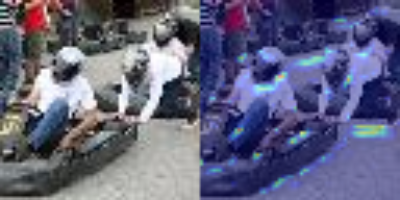

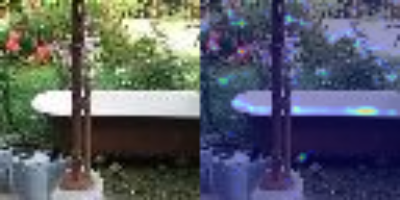

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


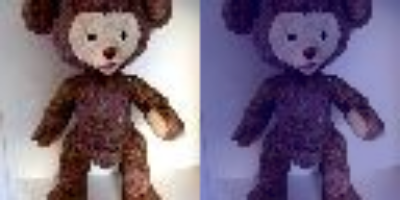

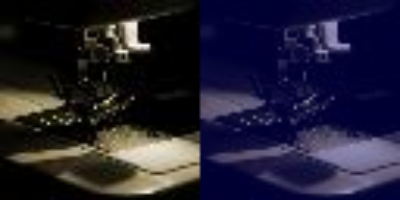

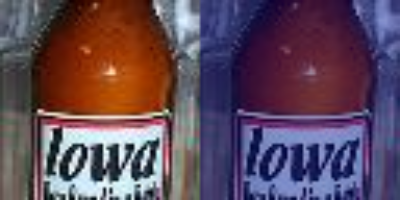

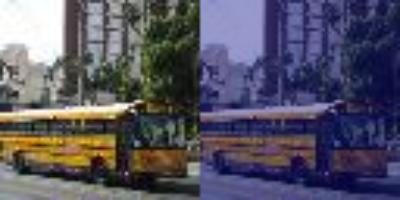

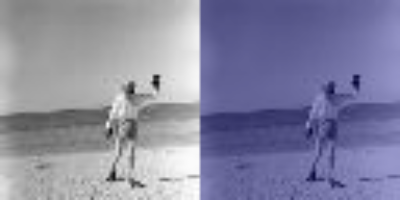

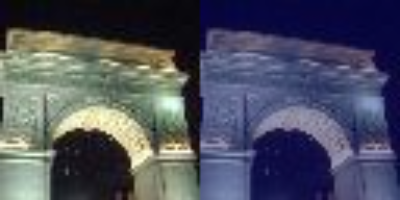

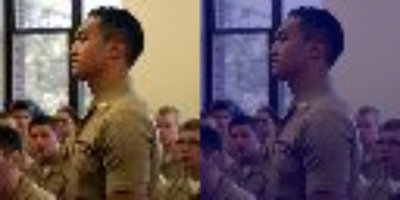

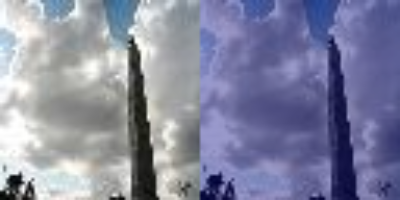

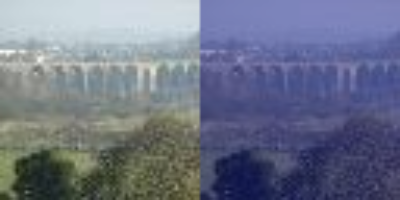

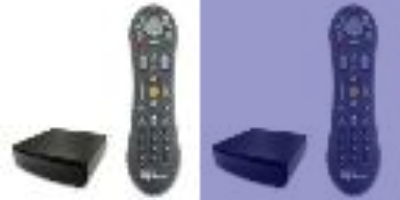

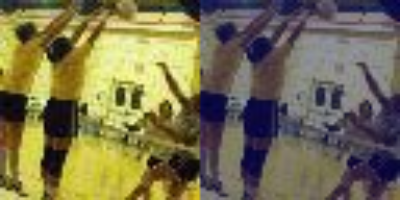

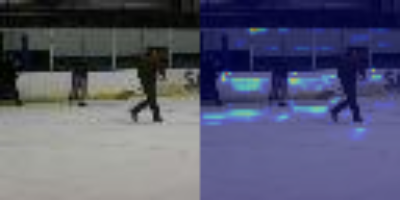

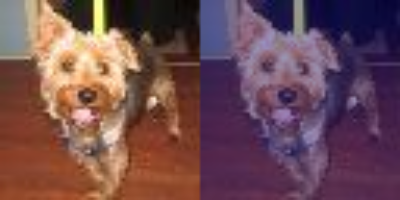

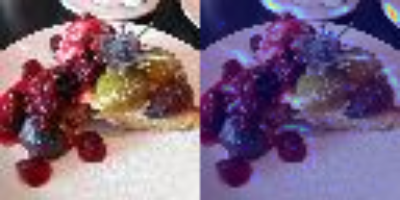

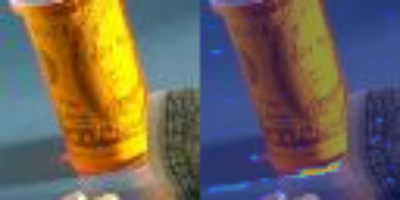

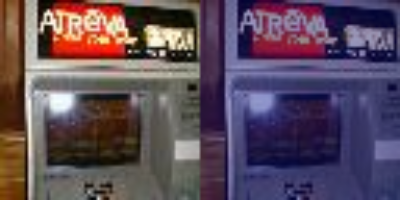

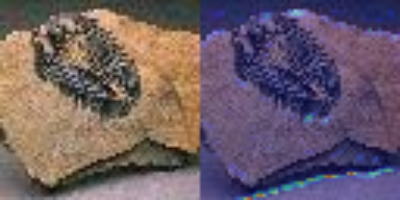

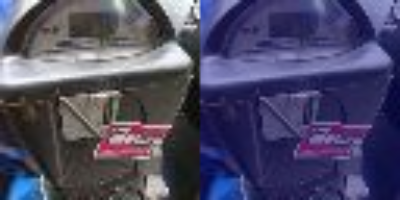

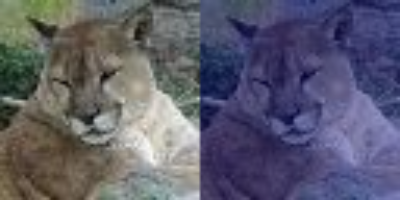

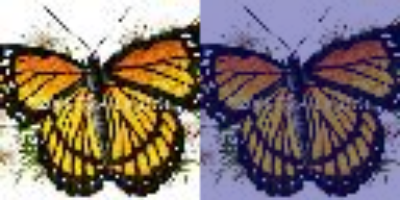

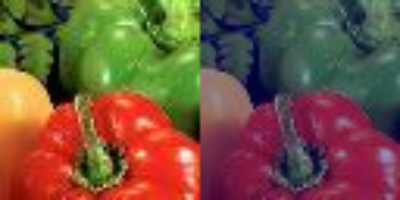

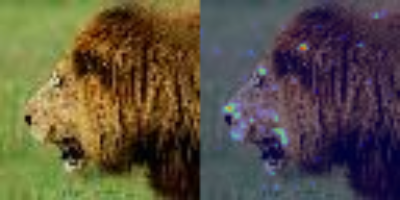

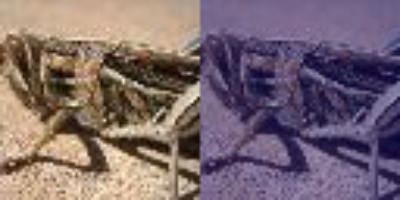

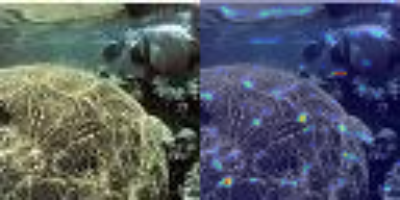

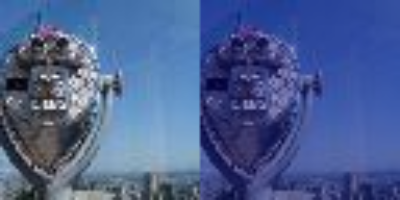

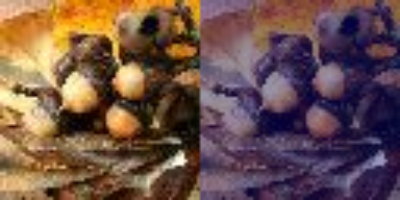

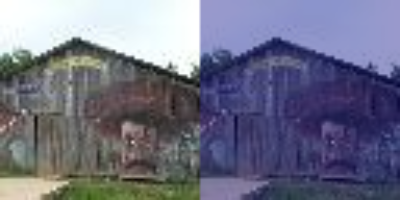

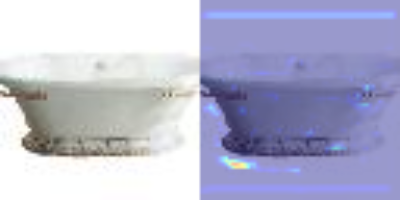

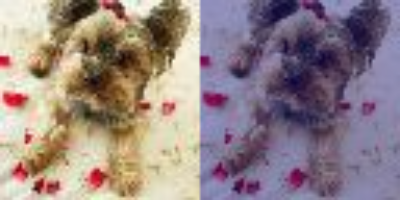

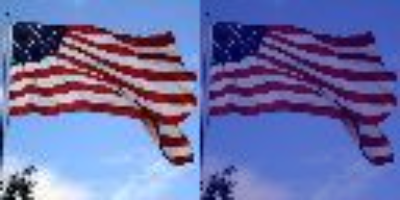

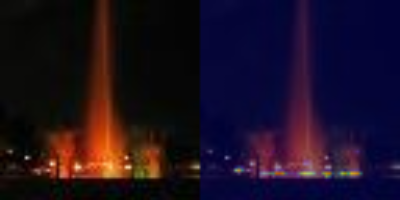

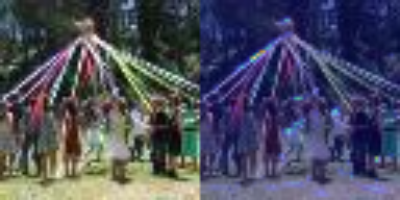

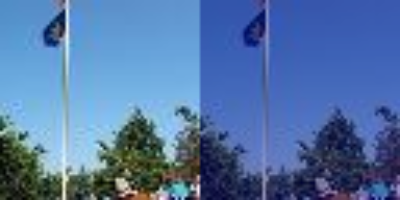

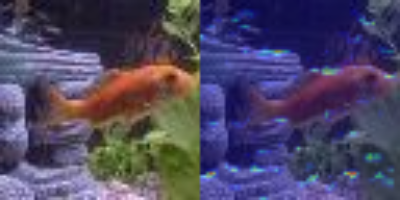

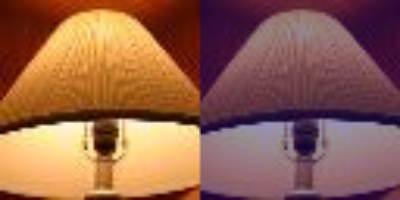

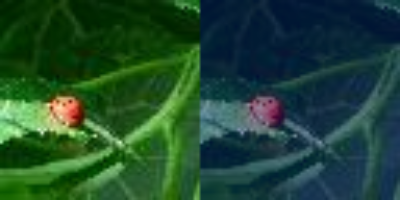

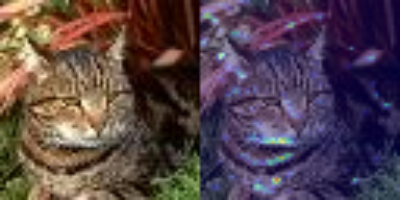

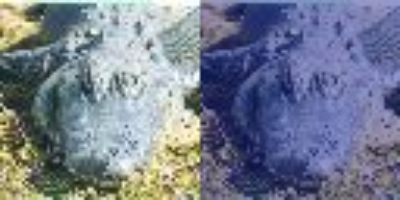

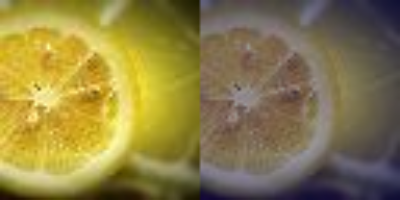

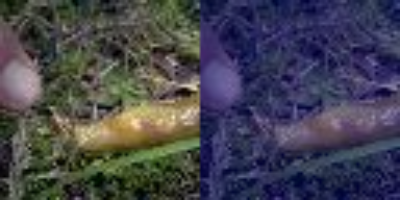

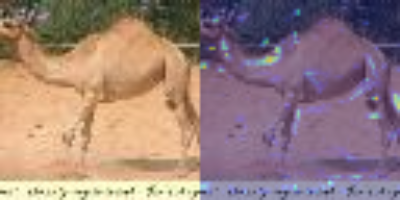

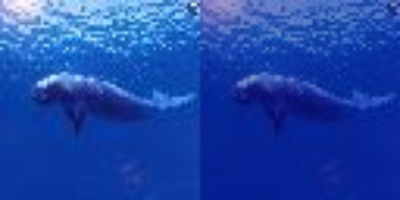

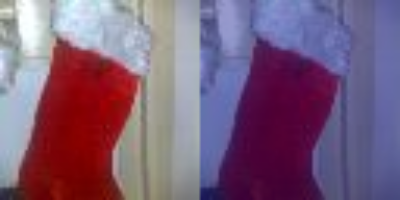

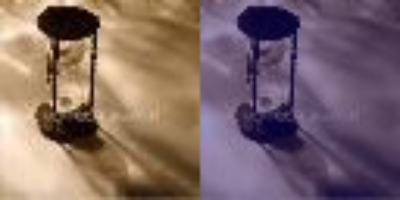

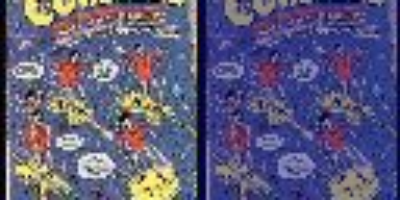

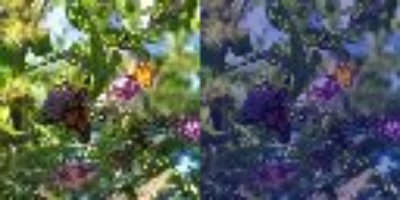

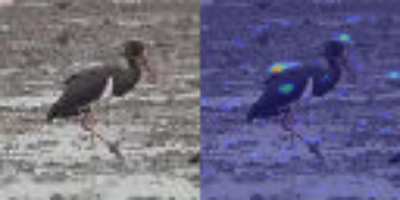

In [0]:
gradcam("conv2d_24") # The final layer according to the model summary is conv2d_24